<a href="https://colab.research.google.com/github/sekihiro/Colabo/blob/master/fashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PyTorchでMNISTをMLPで学習してモデルを保存。そのモデルを読み込んで識別する簡単サンプル(その２)
### https://uchidama.hatenablog.com/entry/2019/09/04/200056
#### http://cedro3.com/ai/pytorch-mlp/
#### https://betashort-lab.com/データサイエンス/ディープラーニング/pytorchでcnn-fashion-mnist編/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%ls -al "/content/drive/My Drive/git/fashion-mnist/input/"
BASE_PATH = "/content/drive/My Drive/git/fashion-mnist/"

total 4
drwx------ 2 root root 4096 Dec  7 08:58 FashionMNIST/


#### MNIST画像は、C,H,W形式で保存されている
#### C=1(モノクロ画像)、HとWは28(ピクセル)

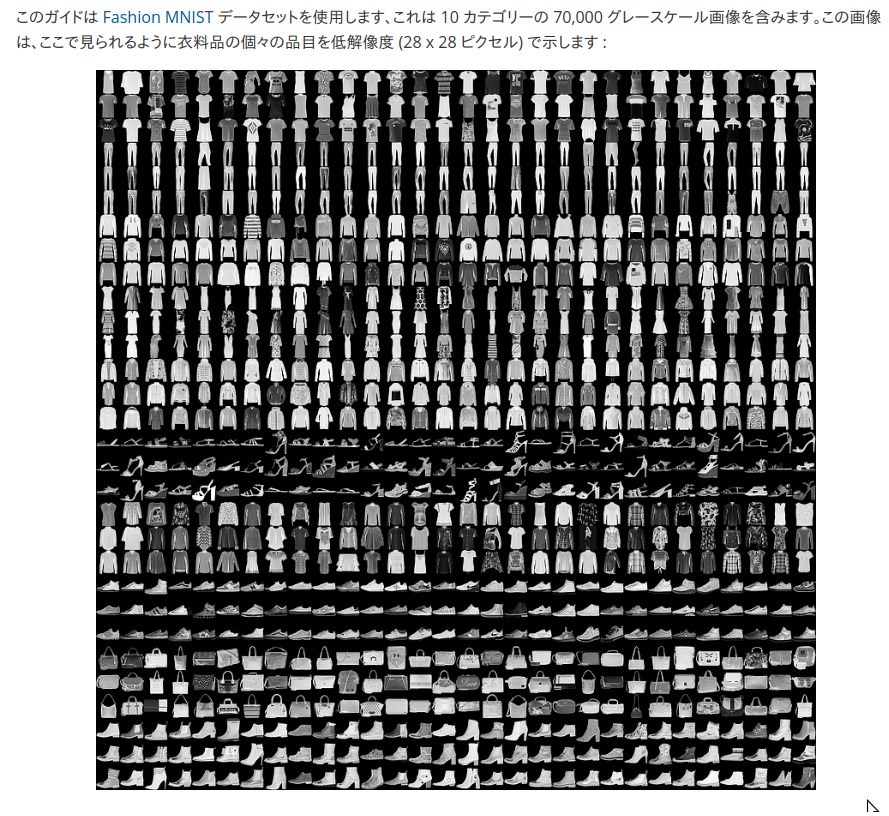

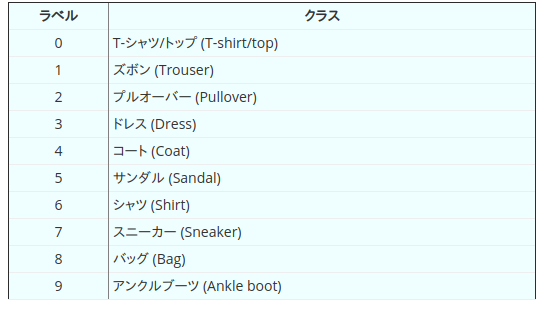

In [4]:
from IPython.display import Image, display_png
display_png(Image("/content/drive/My Drive/git/images/fashion-mnist_001.png"))
display_png(Image("/content/drive/My Drive/git/images/fashion-mnist_002.png"))

In [5]:
!nvidia-smi

Tue Feb 11 06:48:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [7]:
!cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2

#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 5
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


In [0]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import easydict
import time
import math
import random
from tqdm import tqdm
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cloudpickle

In [0]:
# 再現性確保
def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    return seed

In [10]:
# 再現性確保
ret = seed_everything(1234)
print('seed : {}'.format(ret))

# select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device : {}'.format(device))

# load MNIST data
# そのままだとPillow(Python Image Library)形式なので、Tensor形式へ

# 訓練データ
train_dataset = dsets.FashionMNIST(
      root=BASE_PATH + 'input',  # rootで指定したフォルダーを作成して生データを展開
      train=True,  # 学習かテストかの選択
      transform=transforms.ToTensor(),  # PyTroch のテンソルに変換
      download=True)  # ダウンロードするかどうかの選択

# テストデータ
test_dataset = dsets.FashionMNIST(
      root=BASE_PATH + 'input',  
      train=False, 
      transform=transforms.ToTensor(),
      download=True)
 
# 評価データ
tmp_train = math.ceil(len(train_dataset) * 0.8 / 1)
tmp_valid = len(train_dataset) - tmp_train
train_dataset, valid_dataset = torch.utils.data.random_split(  # データセットの分割
      train_dataset,   # 分割するデータセット
      [tmp_train, tmp_valid])  # 分割数

print('train_dataset = ', len(train_dataset))
print('valid_dataset = ', len(valid_dataset))  
print('test_dataset = ', len(test_dataset))

seed : 1234
device : cuda
train_dataset =  48000
valid_dataset =  12000
test_dataset =  10000


10000
10000
(N, C, H, W) = (1, 1, 28, 28)
(N, C, H, W) = (1, 1, 28, 28)
(N, C, H, W) = (1, 1, 28, 28)
(N, C, H, W) = (1, 1, 28, 28)


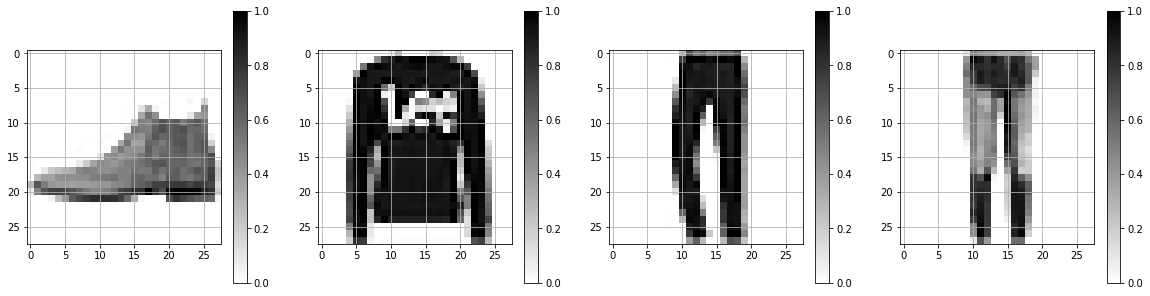

In [11]:
# ******************** wkデータ ******************** #
# どんな画像かを試しに表示してみる

plt.figure(figsize=(20, 5))
wk_num = 4

wk_dataset = dsets.FashionMNIST(
      root=BASE_PATH + 'wk',  
      train=False, 
      transform=transforms.ToTensor(),
      download=True)
wk_loader = torch.utils.data.DataLoader(
      dataset=wk_dataset,
      batch_size=1, 
      shuffle=False,
      num_workers=2)
print(len(wk_dataset))
print(len(wk_loader))
for i, (wk_images, wk_labels) in enumerate(wk_loader):
        wk_numpy_array = wk_images.numpy()

        wk_ret = wk_numpy_array.shape # N,C,H,W
        print('(N, C, H, W) = {}'.format(wk_ret))
        wk_H = wk_ret[2] # H
        wk_W = wk_ret[3] # W

        # 貼り付け
        plt.subplot(1, wk_num, i+1)
        plt.imshow(wk_numpy_array.reshape((wk_H, wk_W)), cmap=cm.gray_r)
        plt.colorbar()
        plt.grid(True)

        if i >= (wk_num-1):
            break

# 画像表示
plt.show()
# ******************** wkデータ ******************** #

In [0]:
# set data loader
batch_size = 128 # 学習する際に一度に使用するデータの数
train_loader = torch.utils.data.DataLoader(
      dataset=train_dataset,  # データセットの指定
      batch_size=batch_size,  # ミニバッチ学習：N個の訓練データの中から、一部n個を取り出し、パラメータ更新する
      shuffle=True,  # シャッフルするかどうかの指定
      num_workers=2)  # コアの数
 
valid_loader = torch.utils.data.DataLoader(
      dataset=valid_dataset,
      batch_size=batch_size, 
      shuffle=False,
      num_workers=2)
 
test_loader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=batch_size, 
      shuffle=False,
      num_workers=2)

In [13]:
# Multi Layer Perceptron Network
class net(nn.Module):
    def __init__(self):
        super(net,self).__init__()
        #畳み込み層(2次元)：特徴を見つけ、粗く整理していく
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 5), # 第１引数は、CHWのCの値と合わせること
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.25),
            nn.Conv2d(32, 64, 5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.25),
        )
        # 
        # Conv2d：畳み込み層：入力チャネル数, 畳み込み後チャネル数, 畳み込みするための正方形フィルタ(カーネル)の1辺サイズ
        # MaxPool2d：MAXプーリング：カーネルサイズ (引数範囲内の最大値を選択しサイズ圧縮)
        # ReLU：活性化関数：次の層に渡す値を整える (ReLU：入力した値が0以下のとき0、1より大きいとき入力をそのまま出力)
        # BatchNorm2d：ネットワーク最適化 (内部変数の分布が大きく変わるのを防ぎ、学習が早くなる、過学習が抑えられる)
        # Dropout2d：ユニットの除外：pの確率でユニットの値を0にして、過学習を防ぐ
        # Linear：線形結合：入力サイズ, 出力サイズ
        #
        #全結合層(1次元)：特徴をまとめて評価につなげる
        self.dence = nn.Sequential(
            nn.Linear( 64* 4 *4, 200), # 第１引数はcheck_cnn_sizeで算出
            nn.ReLU(),
            nn.BatchNorm1d(200),
            nn.Dropout(0.2),
            nn.Linear(200, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 10),
        )
         
    #順伝播
    def forward(self,x):
        #畳み込み層
        out = self.conv_layers(x)
        #Flatten
        #viewで画像の[1,28,28]を１次元に変換
        #引数に-1を入れることで、サイズ数を自動的に調整
        # [N,C,H,W] -> [N(out.size(0)), C*H*W]
        out = out.view(out.size(0), -1)
        #全結合層
        out = self.dence(out)
        return out
     
    #畳み込み層の出力サイズのチェック
    def check_cnn_size(self, size_check):
        out = self.conv_layers(size_check)
        return out

# MLP init
net = net().to(device)
pprint.pprint(net)

# 損失関数：ラベル値と予測値の違いを計算するための関数
# CrossEntropyLoss：多クラス分類 ソフトマックス交差エントロピ
criterion = nn.CrossEntropyLoss()
# 最適化関数(勾配法)：損失関数の最小化を解く手法
# SGD(Stochastic Gradient Descent)：確率的勾配降下法
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

#全結合層の入力サイズの確認
#畳み込み層を通って、Flattenを通ったあと、どのようなサイズになっているか見ておく
size_check = torch.FloatTensor(10, 1, 28, 28) # ラベル10種類、グレースケール(C=1)、画像サイズ(28*28)
size_check = size_check.to(device)
print(net.check_cnn_size(size_check).size()) # ---> torch.Size([10, 64, 4, 4])

net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.25, inplace=False)
  )
  (dence): Sequential(
    (0): Linear(in_features=1024, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=200, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_runn

In [14]:
###  training
print ('training start ...\n')
num_epochs = 50   

# initialize list for plot graph after training
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

for epoch in range(num_epochs):
    # initialize each epoch
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
    
    # ======== train_mode ======
    net.train()
    for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader), desc="[train]"):  # ミニバッチ回数実行
        images, labels = images.to(device), labels.to(device)
        # 毎回バックプロパゲーションの初期値をリセット(勾配リセット)
        optimizer.zero_grad()
        # 順方向の伝播の計算(forwardが呼ばれる)
        outputs = net.forward(images)
        # 損失関数：予測値とラベル値の違いを計算
        loss = criterion(outputs, labels)
        # train_loss に結果を蓄積
        # item()で、Tensorをintへ
        train_loss += loss.item()
        # 10パターンの分類毎に値が取得できるので、最も値が高い分類をmax(1)で取得
        # max(1)の戻り値の[0]はsoftmaxの精度(0〜1)、[1]は予測ラベル
        # 予測とラベルが合っている数の合計
        # sum()は、合っている数をTensor形式でカウント
        # item()で、Tensorをintへ
        acc = (outputs.max(1)[1] == labels).sum()
        # train_acc に結果を蓄積
        train_acc += acc.item()
        # 誤差のバックプロパゲーション(逆伝播)で勾配を求める
        loss.backward()
        # バックプロパゲーションで計算した勾配を元に重みを更新
        optimizer.step()
    
    # lossの平均を計算
    avg_train_loss = train_loss / len(train_loader.dataset)
    # accの平均を計算
    avg_train_acc = train_acc / len(train_loader.dataset)

    # ======== valid_mode ======
    net.eval()
    # torch.no_gradで必要のない計算を停止 パラメータの保存を止める(test時にメモリが溢れてしまうのを防止)
    with torch.no_grad():
      for images, labels in tqdm(valid_loader, total=len(valid_loader), desc="[valid]"):
          images, labels = images.to(device), labels.to(device)
          outputs = net.forward(images)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          val_acc += acc.item()
    
    avg_val_loss = val_loss / len(valid_loader.dataset)
    avg_val_acc = val_acc / len(valid_loader.dataset)
    
    # print log
    print ('\nEpoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))

    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

print ('training end ...')

training start ...



[valid]: 100%|██████████| 94/94 [00:01<00:00, 73.20it/s]


Epoch [1/50], Loss: 0.0047, val_loss: 0.0029, val_acc: 0.8653



[valid]: 100%|██████████| 94/94 [00:01<00:00, 74.31it/s]


Epoch [2/50], Loss: 0.0031, val_loss: 0.0023, val_acc: 0.8889



[valid]: 100%|██████████| 94/94 [00:01<00:00, 69.20it/s]


Epoch [3/50], Loss: 0.0027, val_loss: 0.0022, val_acc: 0.8925



[valid]: 100%|██████████| 94/94 [00:01<00:00, 73.96it/s]


Epoch [4/50], Loss: 0.0025, val_loss: 0.0021, val_acc: 0.9009



[valid]: 100%|██████████| 94/94 [00:01<00:00, 73.34it/s]


Epoch [5/50], Loss: 0.0023, val_loss: 0.0021, val_acc: 0.8995



[valid]: 100%|██████████| 94/94 [00:01<00:00, 74.46it/s]


Epoch [6/50], Loss: 0.0022, val_loss: 0.0020, val_acc: 0.9002



[valid]: 100%|██████████| 94/94 [00:01<00:00, 72.96it/s]


Epoch [7/50], Loss: 0.0021, val_loss: 0.0020, val_acc: 0.9066



[valid]: 100%|██████████| 94/94 [00:01<00:00, 72.20it/s]


Epoch [8/50], Loss: 0.0021, val_loss: 0.0019, val_acc: 0.9073



[valid]: 100%|██████████| 94/94 [00:01<00:00, 71.60it/s]


Epoch [9/50], Loss: 0.0020, val_loss: 0.0019, val_acc: 0.9123



[valid]: 100%|██████████| 94/94 [00:01<00:00, 73.52it/s]


Epoch [10/50], Loss: 0.0019, val_loss: 0.0019, val_acc: 0.9116



[valid]: 100%|██████████| 94/94 [00:01<00:00, 73.58it/s]


Epoch [11/50], Loss: 0.0019, val_loss: 0.0019, val_acc: 0.9101



[valid]: 100%|██████████| 94/94 [00:01<00:00, 70.37it/s]


Epoch [12/50], Loss: 0.0018, val_loss: 0.0018, val_acc: 0.9164



[valid]: 100%|██████████| 94/94 [00:01<00:00, 72.57it/s]


Epoch [13/50], Loss: 0.0018, val_loss: 0.0019, val_acc: 0.9146



[valid]: 100%|██████████| 94/94 [00:01<00:00, 73.52it/s]


Epoch [14/50], Loss: 0.0017, val_loss: 0.0021, val_acc: 0.9028



[valid]: 100%|██████████| 94/94 [00:01<00:00, 73.89it/s]


Epoch [15/50], Loss: 0.0017, val_loss: 0.0018, val_acc: 0.9137



[valid]: 100%|██████████| 94/94 [00:01<00:00, 74.72it/s]


Epoch [16/50], Loss: 0.0017, val_loss: 0.0018, val_acc: 0.9151



[valid]: 100%|██████████| 94/94 [00:01<00:00, 71.51it/s]


Epoch [17/50], Loss: 0.0017, val_loss: 0.0018, val_acc: 0.9186



[valid]: 100%|██████████| 94/94 [00:01<00:00, 70.61it/s]


Epoch [18/50], Loss: 0.0016, val_loss: 0.0020, val_acc: 0.9045



[valid]: 100%|██████████| 94/94 [00:01<00:00, 73.95it/s]


Epoch [19/50], Loss: 0.0016, val_loss: 0.0019, val_acc: 0.9158



[valid]: 100%|██████████| 94/94 [00:01<00:00, 69.35it/s]


Epoch [20/50], Loss: 0.0015, val_loss: 0.0018, val_acc: 0.9197



[valid]: 100%|██████████| 94/94 [00:01<00:00, 73.78it/s]


Epoch [21/50], Loss: 0.0015, val_loss: 0.0018, val_acc: 0.9206



[valid]: 100%|██████████| 94/94 [00:01<00:00, 70.63it/s]


Epoch [22/50], Loss: 0.0015, val_loss: 0.0018, val_acc: 0.9183



[valid]: 100%|██████████| 94/94 [00:01<00:00, 66.49it/s]


Epoch [23/50], Loss: 0.0015, val_loss: 0.0018, val_acc: 0.9224



[valid]: 100%|██████████| 94/94 [00:01<00:00, 72.52it/s]


Epoch [24/50], Loss: 0.0014, val_loss: 0.0019, val_acc: 0.9172



[valid]: 100%|██████████| 94/94 [00:01<00:00, 74.34it/s]


Epoch [25/50], Loss: 0.0014, val_loss: 0.0019, val_acc: 0.9155



[valid]: 100%|██████████| 94/94 [00:01<00:00, 73.67it/s]


Epoch [26/50], Loss: 0.0014, val_loss: 0.0018, val_acc: 0.9203



[valid]: 100%|██████████| 94/94 [00:01<00:00, 70.95it/s]


Epoch [27/50], Loss: 0.0014, val_loss: 0.0018, val_acc: 0.9197



[valid]: 100%|██████████| 94/94 [00:01<00:00, 67.83it/s]


Epoch [28/50], Loss: 0.0014, val_loss: 0.0018, val_acc: 0.9232



[valid]: 100%|██████████| 94/94 [00:01<00:00, 74.33it/s]


Epoch [29/50], Loss: 0.0014, val_loss: 0.0018, val_acc: 0.9197



[valid]: 100%|██████████| 94/94 [00:01<00:00, 74.05it/s]


Epoch [30/50], Loss: 0.0013, val_loss: 0.0018, val_acc: 0.9174



[valid]: 100%|██████████| 94/94 [00:01<00:00, 74.38it/s]


Epoch [31/50], Loss: 0.0013, val_loss: 0.0020, val_acc: 0.9173



[valid]: 100%|██████████| 94/94 [00:01<00:00, 73.89it/s]


Epoch [32/50], Loss: 0.0013, val_loss: 0.0019, val_acc: 0.9188



[valid]: 100%|██████████| 94/94 [00:01<00:00, 72.34it/s]


Epoch [33/50], Loss: 0.0013, val_loss: 0.0018, val_acc: 0.9208



[valid]: 100%|██████████| 94/94 [00:01<00:00, 70.83it/s]


Epoch [34/50], Loss: 0.0013, val_loss: 0.0018, val_acc: 0.9198



[valid]: 100%|██████████| 94/94 [00:01<00:00, 70.79it/s]


Epoch [35/50], Loss: 0.0013, val_loss: 0.0018, val_acc: 0.9203



[valid]: 100%|██████████| 94/94 [00:01<00:00, 66.92it/s]


Epoch [36/50], Loss: 0.0013, val_loss: 0.0019, val_acc: 0.9176



[valid]: 100%|██████████| 94/94 [00:01<00:00, 73.41it/s]


Epoch [37/50], Loss: 0.0012, val_loss: 0.0019, val_acc: 0.9180



[valid]: 100%|██████████| 94/94 [00:01<00:00, 70.82it/s]


Epoch [38/50], Loss: 0.0013, val_loss: 0.0018, val_acc: 0.9210



[valid]: 100%|██████████| 94/94 [00:01<00:00, 72.89it/s]


Epoch [39/50], Loss: 0.0012, val_loss: 0.0019, val_acc: 0.9213



[valid]: 100%|██████████| 94/94 [00:01<00:00, 75.70it/s]


Epoch [40/50], Loss: 0.0012, val_loss: 0.0018, val_acc: 0.9186



[valid]: 100%|██████████| 94/94 [00:01<00:00, 77.33it/s]


Epoch [41/50], Loss: 0.0012, val_loss: 0.0019, val_acc: 0.9203



[valid]: 100%|██████████| 94/94 [00:01<00:00, 76.44it/s]


Epoch [42/50], Loss: 0.0012, val_loss: 0.0018, val_acc: 0.9197



[valid]: 100%|██████████| 94/94 [00:01<00:00, 77.65it/s]


Epoch [43/50], Loss: 0.0012, val_loss: 0.0019, val_acc: 0.9211



[valid]: 100%|██████████| 94/94 [00:01<00:00, 70.62it/s]


Epoch [44/50], Loss: 0.0012, val_loss: 0.0018, val_acc: 0.9202



[valid]: 100%|██████████| 94/94 [00:01<00:00, 66.63it/s]


Epoch [45/50], Loss: 0.0012, val_loss: 0.0018, val_acc: 0.9220



[valid]: 100%|██████████| 94/94 [00:01<00:00, 74.52it/s]


Epoch [46/50], Loss: 0.0012, val_loss: 0.0018, val_acc: 0.9219



[valid]: 100%|██████████| 94/94 [00:01<00:00, 73.27it/s]


Epoch [47/50], Loss: 0.0012, val_loss: 0.0019, val_acc: 0.9202



[valid]: 100%|██████████| 94/94 [00:01<00:00, 79.79it/s]



Epoch [48/50], Loss: 0.0011, val_loss: 0.0018, val_acc: 0.9251


[valid]: 100%|██████████| 94/94 [00:01<00:00, 77.72it/s]


Epoch [49/50], Loss: 0.0011, val_loss: 0.0018, val_acc: 0.9211



[valid]: 100%|██████████| 94/94 [00:01<00:00, 78.18it/s]


Epoch [50/50], Loss: 0.0011, val_loss: 0.0018, val_acc: 0.9255
training end ...


len(test_loader):79




[test]: 100%|██████████| 79/79 [00:01<00:00, 78.82it/s]


test_accuracy: 91.93 %


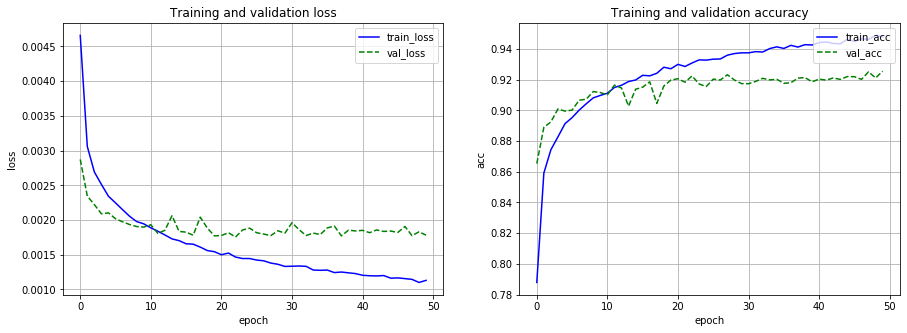

In [15]:
# ======== fainal test ======
print("len(test_loader):{}\n\n".format(len(test_loader)))
time.sleep(1)

net.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in tqdm(test_loader, total=len(test_loader), desc="[test]"):
        images, labels = images.to(device), labels.to(device)
        # 10パターンの分類毎に値が取得できるので、最も値が高い分類をmax(1)で取得
        # max(1)の戻り値の[0]はsoftmaxの精度(0〜1)、[1]は予測ラベル
        outputs = net.forward(images)
        # 予測ラベル と testデータのラベル が合っている数をカウント
        # sum()は、合っている数をTensor形式でカウント
        # item()で、Tensorをintへ
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        #pprint.pprint(labels)
        #print(type(labels))
        #print(labels.size(0))
        total += labels.size(0) # データ個数
    print('test_accuracy: {} %'.format(100 * test_acc / total)) 

# save model
with open(BASE_PATH + 'model/mnist_net.pkl', 'wb') as f:
    cloudpickle.dump(net, f)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()


net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.25, inplace=False)
  )
  (dence): Sequential(
    (0): Linear(in_features=1024, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=200, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_runn

[prediction]:  99%|█████████▉| 99/100 [00:01<00:00, 63.58it/s]


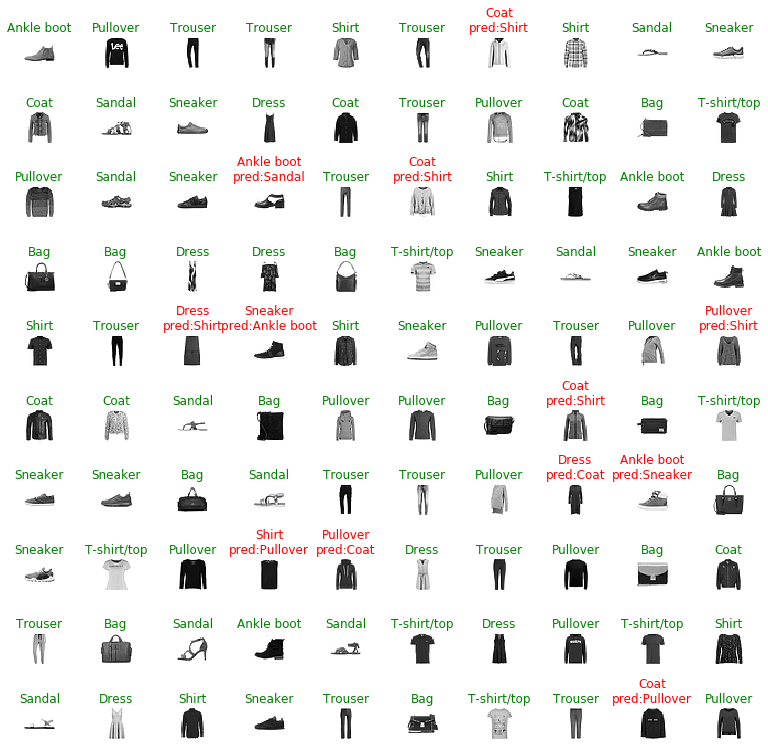

In [16]:
# model load
with open(BASE_PATH + 'model/mnist_net.pkl', 'rb') as f:
    net = cloudpickle.load(f).to(device)

pprint.pprint(net)

net.eval()

# test data load (バッチサイズは１とする)
test_loader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=1, 
      shuffle=False,
      num_workers=2)

#classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))
#pprint.pprint(classes)

# 100件分の正誤がわかる図を表示
H = 10
W = 10
fig = plt.figure(figsize=(H, W))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1.0, hspace=0.5, wspace=1.5)

fashion_mnist_labels = np.array([
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'])

limit_size = 100
for i, (images, label) in tqdm(enumerate(test_loader), total=limit_size, desc="[prediction]"):

    resize_images, labels = images.to(device), labels.to(device)
    # 10パターンの分類毎に値が取得できるので、最も値が高い分類を取得
    output = net.forward(resize_images)
    #pprint.pprint(output)
    value, prediction = torch.max(output, 1)

    plt.subplot(H, W, i+1)
    # 画像を表示させるために、PyTorch.Tensor型からPIL型へ
    numpy_array = images.numpy()
    #print(numpy_array.shape)
    plt.imshow(numpy_array.reshape((28, 28)),  cmap=cm.gray_r) # 背景を白にする(grayの反転)
    plt.axis('off')
  
    # モデルから取得した予測値 と テストデータに記載されている正解ラベル を比較
    if prediction[0].item() == label:
        plt.title(fashion_mnist_labels[prediction[0].item()], fontsize=12, color = "green")
    else:
        plt.title("{}\npred:{}".format(fashion_mnist_labels[label.item()], fashion_mnist_labels[prediction[0].item()]), fontsize=12, color = "red")

    if i >= (limit_size - 1):
        break

plt.show()

# EOF #